In [546]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import dice_ml
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm


In [547]:
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)
dic = {'x':data[:,0], 'y' : data[:,1], 'target': labels}
df = pd.DataFrame(data = dic)


In [548]:
data_dice = dice_ml.Data(dataframe=df, continuous_features=['x','y'], outcome_name='target')

In [549]:
X = df[['x','y']].values
y = df[['target']].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dic_train = {'x':x_train[:,0], 'y' : x_train[:,1], 'target': y_train.flatten()}
df_train = pd.DataFrame(data = dic_train)
dic_test = {'x':x_test[:,0], 'y' : x_test[:,1], 'target': y_test.flatten()}
df_test = pd.DataFrame(data = dic_test)
data_dice_test = dice_ml.Data(dataframe=df_test, continuous_features=['x','y'], outcome_name='target')

In [550]:
def plot_decision_boundary(pred_func,X,y,title, obs, enemy):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # Set min and max values and give it some padding
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    plt.scatter(obs[0], obs[1], c = 'lime',marker= 'x')
    plt.scatter(enemy.T[0], enemy.T[1], c = 'red', marker = 'o')
    plt.title(title)
    plt.show()

In [551]:
def grad(x_train, y_train, model, critetion, epochs=100, learning_rate=0.01):
    #print(x_train)
    #print(y_train)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = Variable(torch.from_numpy(x_train.astype(np.float32)).cuda())
            labels = Variable(torch.from_numpy(y_train.astype(np.float32)).cuda())
        else:
            inputs = Variable(torch.from_numpy(x_train.astype(np.float32)))
            labels = Variable(torch.from_numpy(y_train.astype(np.float32)))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        # get output from the model, given the inputs
        outputs = model(inputs)
        # geloss for the predicted output
        #print(outputs)
        loss = criterion(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()

def predict(x, model):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor)
    #Predict and return ans
    ans = model.predict(x)
    return ans.numpy()

In [552]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.activation = torch.nn.ReLU()
        

    def forward(self, x):
        #out = self.linear(x)
        out = self.activation(self.linear(x))
        return out
    
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = self.forward(x)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>0.5:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [553]:
class res2D(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize,outputSize):
        super().__init__()
        self.linear1 = torch.nn.Linear(inputSize, hiddenSize)
        self.activation1 = torch.nn.ELU()
        self.linear2 = torch.nn.Linear(hiddenSize, outputSize)
        self.activation2 = torch.nn.Sigmoid()        

    def forward(self, x):
        out = self.activation2(self.linear2(self.activation1(self.linear1(x))))
        return out
    
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = self.forward(x)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>0.5:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [ ]:
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=66
query_instance = dict(zip(['x','y'], x_test[index]))
counterfactuals = explainer.generate_counterfactuals(
                    query_instance=query_instance,total_CFs=1, proximity_weight=0.9,desired_class='opposite')
counterfactuals.visualize_as_dataframe()
#plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

In [ ]:
plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "RegLog",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[:,:2])

In [ ]:
counterfactuals.cf_examples_list[0].final_cfs_df.values[:,:2]

In [ ]:
model = res2D(2,20,1)
criterion = torch.nn.BCELoss()

grad(x_train, y_train, model, criterion, epochs=1000)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=77
query_instance = dict(zip(['x','y'], x_test[index]))
counterfactuals = explainer.generate_counterfactuals(
                    query_instance=query_instance,total_CFs=1, desired_class='opposite')
counterfactuals.visualize_as_dataframe()

In [ ]:
plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "NN 2 dim",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

In [ ]:
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=66
query_instance = dict(zip(['x','y'], x_test[index]))
proximity_weights = np.linspace(0.01, 0.9, num=10)
pred_ori = counterfactuals.cf_examples_list[0].test_pred
for proximity_weight in tqdm(proximity_weights):
    counterfactuals = explainer.generate_counterfactuals(
                        query_instance=query_instance,total_CFs=2, proximity_weight=proximity_weight,desired_class='opposite')
    print(proximity_weight)
    
    counterfactuals.visualize_as_dataframe()
    a =counterfactuals.cf_examples_list[0].final_cfs_df.values
    print(a)
    tmp = []
    for l in a:
        if (l[2] < 0.5 and pred_ori < 0.5) or (l[2] >= 0.5 and pred_ori>=0.5) :
            tmp.append(1)
        else:
            tmp.append(0)
    print(tmp)
#plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "",x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

In [ ]:
index=55
query_instance = dict(zip(['x','y'], x_test[index]))
counterfactuals = explainer.generate_counterfactuals(
                        query_instance=query_instance,total_CFs=3,desired_class='opposite')
counterfactuals.visualize_as_dataframe()
counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2]

  0%|                                                    | 0/15 [00:00<?, ?it/s]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
0.1
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,2.356059,-0.915829,0


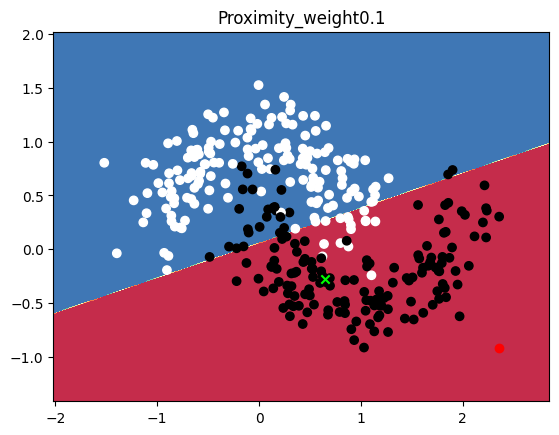

  7%|██▉                                         | 1/15 [00:01<00:19,  1.38s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 01 sec
0.8071428571428572
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.709276,-0.915829,0


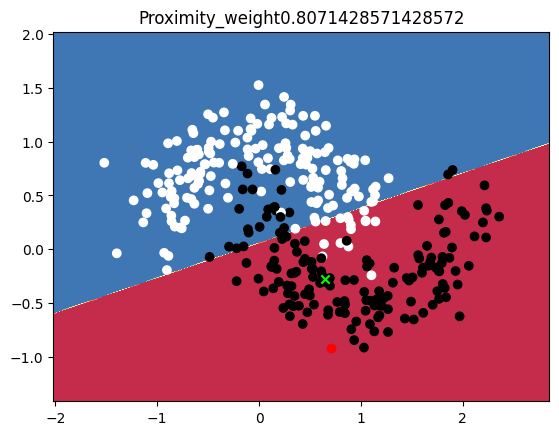

 13%|█████▊                                      | 2/15 [00:04<00:31,  2.43s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 02 sec
1.5142857142857145
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.6886,-0.359001,0


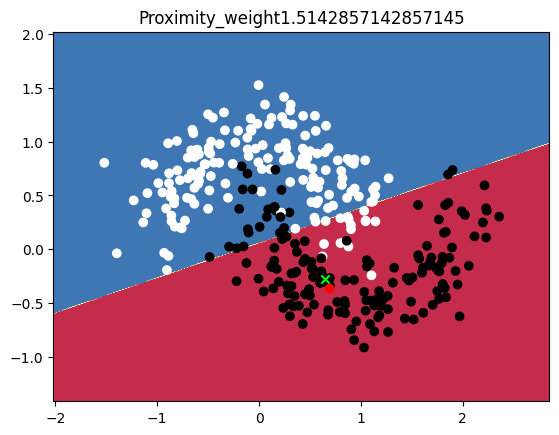

 20%|████████▊                                   | 3/15 [00:08<00:36,  3.07s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 02 sec
2.2214285714285715
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.653746,-0.327526,0


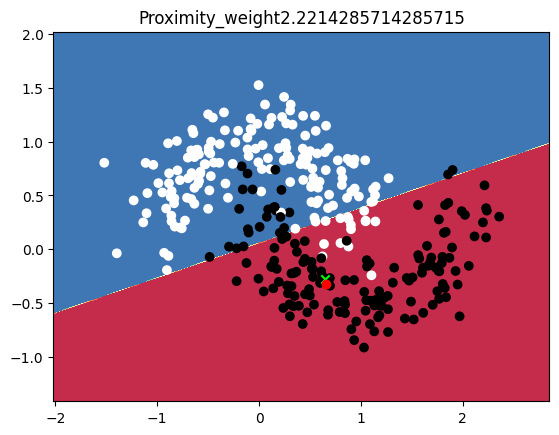

 27%|███████████▋                                | 4/15 [00:12<00:38,  3.49s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 02 sec
2.928571428571429
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.658937,-0.326533,0


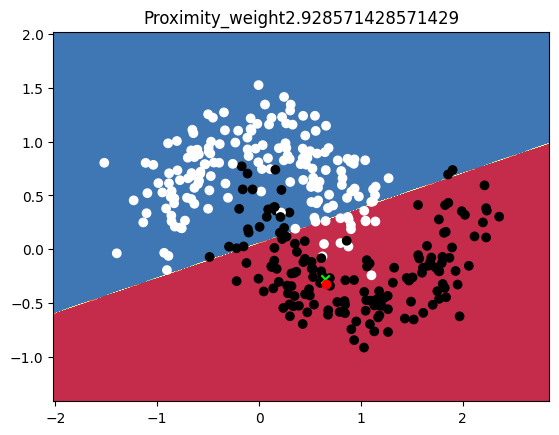

 33%|██████████████▋                             | 5/15 [00:16<00:35,  3.57s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 02 sec
3.635714285714286
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.721174,-0.314152,0


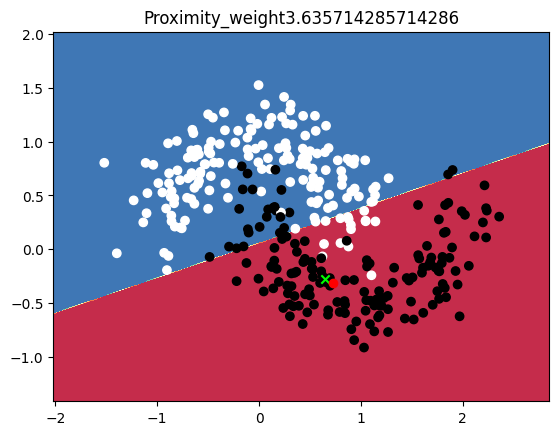

 40%|█████████████████▌                          | 6/15 [00:20<00:33,  3.73s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 02 sec
4.3428571428571425
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.679623,-0.322389,0


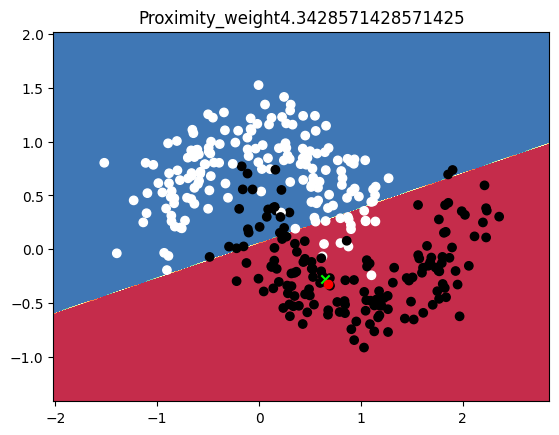

 47%|████████████████████▌                       | 7/15 [00:24<00:30,  3.80s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 04 sec
5.05
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.652815,-0.32774,0


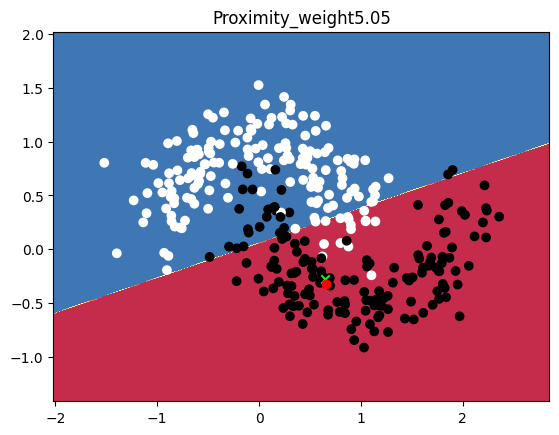

 53%|███████████████████████▍                    | 8/15 [00:30<00:31,  4.54s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 04 sec
5.757142857142857
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.695594,-0.319232,0


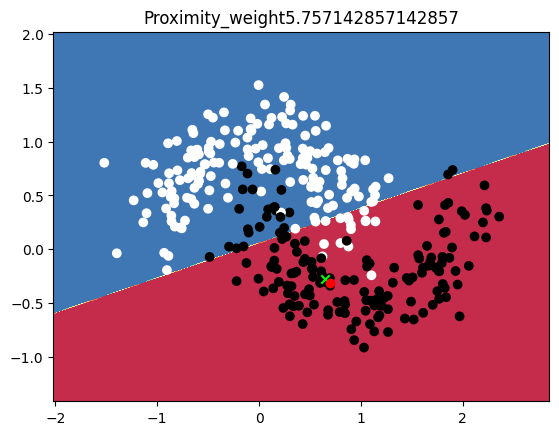

 60%|██████████████████████████▍                 | 9/15 [00:36<00:29,  5.00s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
6.464285714285714
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.660264,-0.326362,0


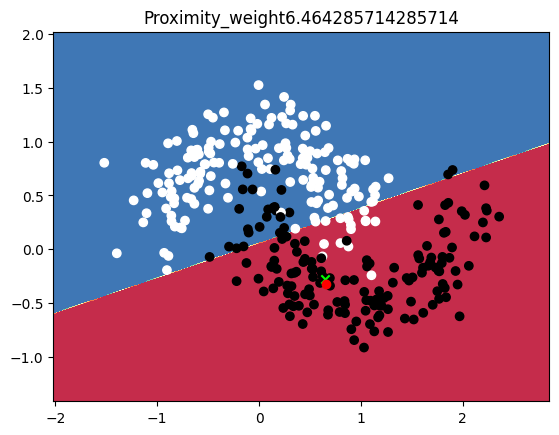

 67%|████████████████████████████▋              | 10/15 [00:41<00:25,  5.06s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
7.171428571428572
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.693722,-0.319773,0


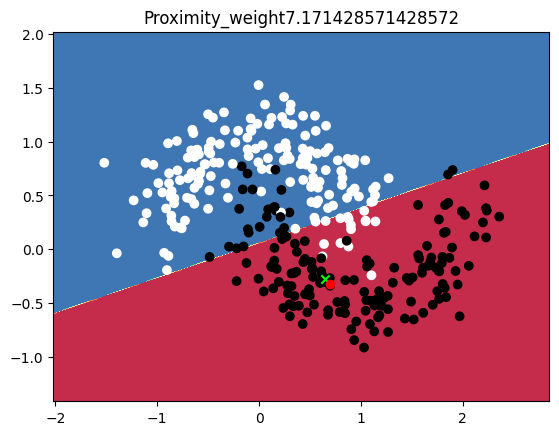

 73%|███████████████████████████████▌           | 11/15 [00:45<00:19,  4.79s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
7.878571428571429
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.698707,-0.318615,0


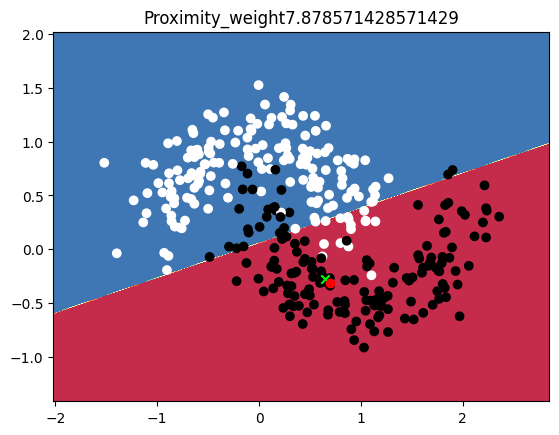

 80%|██████████████████████████████████▍        | 12/15 [00:50<00:14,  4.82s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
8.585714285714285
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.655546,-0.327165,0


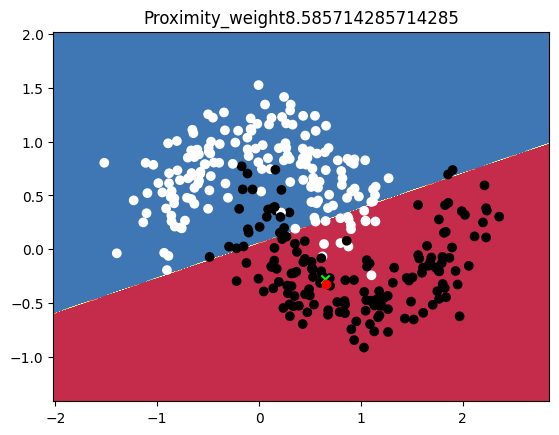

 87%|█████████████████████████████████████▎     | 13/15 [00:56<00:10,  5.02s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
9.292857142857143
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.648919,-0.328471,0


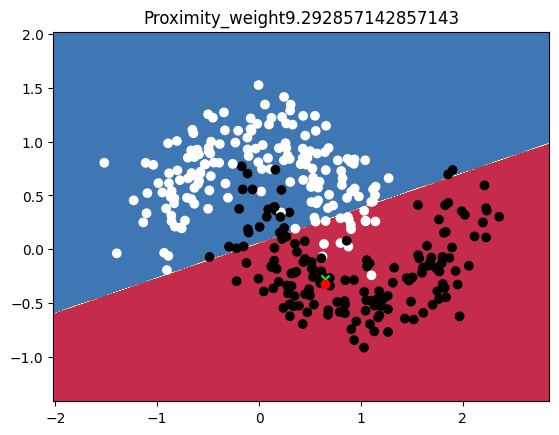

 93%|████████████████████████████████████████▏  | 14/15 [01:01<00:05,  5.09s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 03 sec
10.0
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.488



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.714737,-0.315551,0


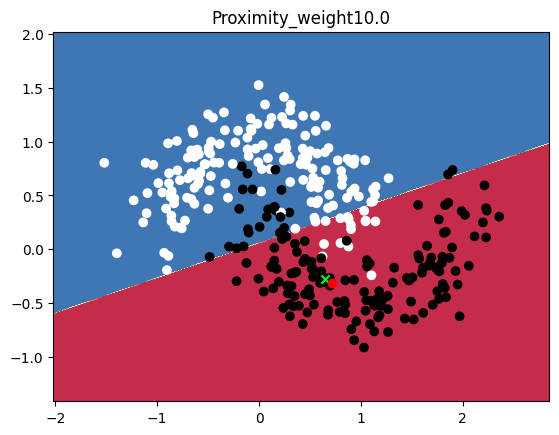

100%|███████████████████████████████████████████| 15/15 [01:06<00:00,  4.43s/it]


In [554]:
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=74
query_instance = dict(zip(['x','y'], x_test[index]))
proximity_weights = np.linspace(0.1, 10, num=15)
pred_ori = counterfactuals.cf_examples_list[0].test_pred
for proximity_weight in tqdm(proximity_weights):
    counterfactuals = explainer.generate_counterfactuals(
                        query_instance=query_instance,total_CFs=1, proximity_weight=proximity_weight,desired_class='opposite')
    print(proximity_weight)
    
    counterfactuals.visualize_as_dataframe()
    if len(counterfactuals.cf_examples_list[0].final_cfs_df.values) >0 :
        plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "Proximity_weight"+str(proximity_weight),x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

  0%|                                                    | 0/15 [00:00<?, ?it/s]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
0.1
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,2.348073,-0.915829,0


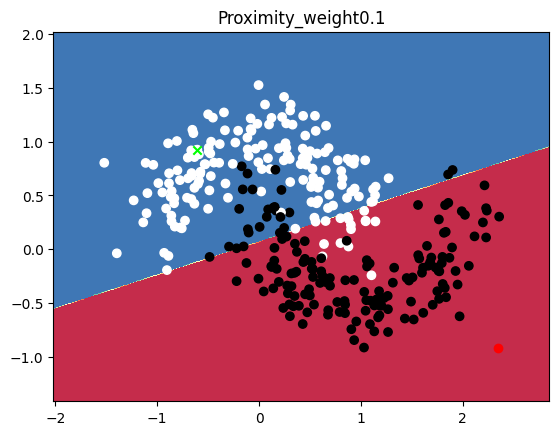

  7%|██▉                                         | 1/15 [00:01<00:22,  1.59s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
0.6642857142857143
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,-0.605074,-0.915829,0


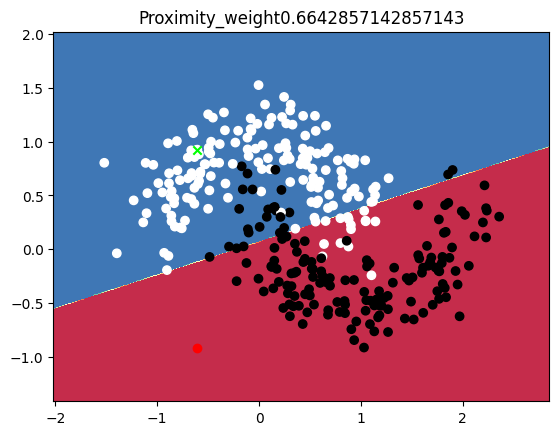

 13%|█████▊                                      | 2/15 [00:03<00:24,  1.86s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 04 sec
1.2285714285714286
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 20%|████████▊                                   | 3/15 [00:08<00:36,  3.00s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 04 sec
1.792857142857143
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 27%|███████████▋                                | 4/15 [00:12<00:37,  3.45s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
2.357142857142857
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 33%|██████████████▋                             | 5/15 [00:15<00:35,  3.52s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
2.9214285714285713
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 40%|█████████████████▌                          | 6/15 [00:19<00:30,  3.42s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
3.4857142857142858
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 47%|████████████████████▌                       | 7/15 [00:22<00:26,  3.34s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
4.05
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 53%|███████████████████████▍                    | 8/15 [00:25<00:22,  3.27s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
4.614285714285714
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 60%|██████████████████████████▍                 | 9/15 [00:28<00:19,  3.24s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
5.178571428571428
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 67%|████████████████████████████▋              | 10/15 [00:31<00:16,  3.21s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
5.742857142857142
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 73%|███████████████████████████████▌           | 11/15 [00:34<00:13,  3.26s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
6.307142857142857
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 80%|██████████████████████████████████▍        | 12/15 [00:38<00:10,  3.44s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
6.871428571428571
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 87%|█████████████████████████████████████▎     | 13/15 [00:42<00:07,  3.61s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
7.435714285714285
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


 93%|████████████████████████████████████████▏  | 14/15 [00:46<00:03,  3.63s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)



No counterfactuals found!
No Counterfactuals found for the given configuation,  perhaps try with different values of proximity (or diversity) weights or learning rate... ; total time taken: 00 min 03 sec
8.0
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,-0.605914,0.926221,0.124


100%|███████████████████████████████████████████| 15/15 [00:49<00:00,  3.31s/it]


No counterfactuals found!


In [565]:
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=66
query_instance = dict(zip(['x','y'], x_test[index]))
proximity_weights = np.linspace(0.1, 8, num=15)
pred_ori = counterfactuals.cf_examples_list[0].test_pred
for proximity_weight in tqdm(proximity_weights):
    counterfactuals = explainer.generate_counterfactuals(
                        query_instance=query_instance,total_CFs=1, proximity_weight=proximity_weight,desired_class='opposite')
    print(proximity_weight)
    
    counterfactuals.visualize_as_dataframe()
    if len(counterfactuals.cf_examples_list[0].final_cfs_df.values) >0 :
        plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "Proximity_weight"+str(proximity_weight),x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

  0%|                                                    | 0/15 [00:00<?, ?it/s]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
0.1
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


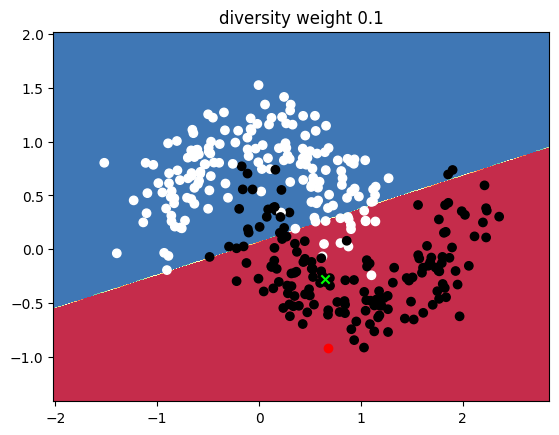

  7%|██▉                                         | 1/15 [00:01<00:22,  1.59s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
0.8071428571428572
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


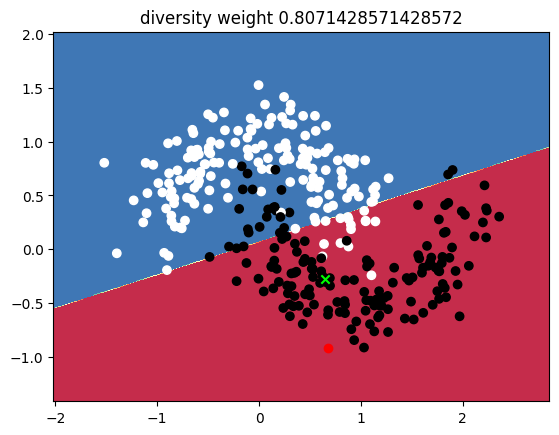

 13%|█████▊                                      | 2/15 [00:03<00:19,  1.51s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
1.5142857142857145
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


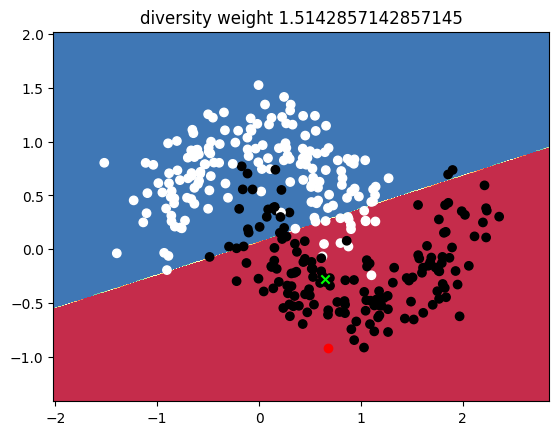

 20%|████████▊                                   | 3/15 [00:04<00:19,  1.60s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
2.2214285714285715
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


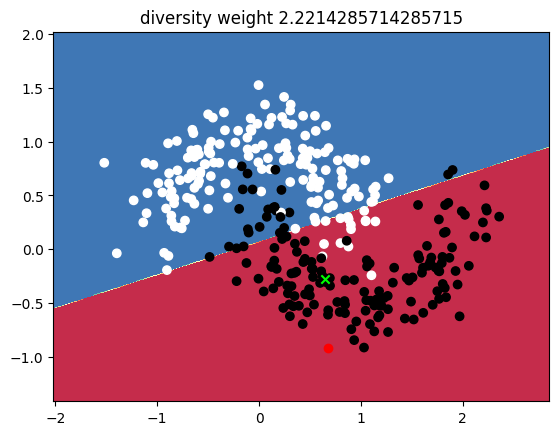

 27%|███████████▋                                | 4/15 [00:06<00:16,  1.53s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
2.928571428571429
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


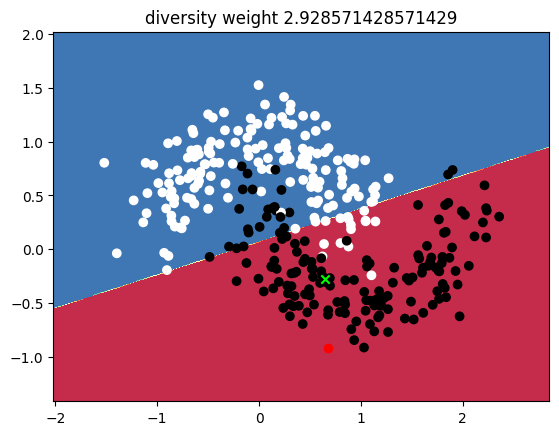

 33%|██████████████▋                             | 5/15 [00:07<00:15,  1.57s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
3.635714285714286
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


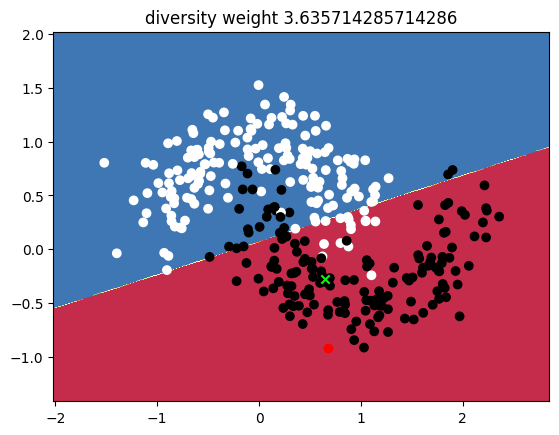

 40%|█████████████████▌                          | 6/15 [00:09<00:13,  1.52s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
4.3428571428571425
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


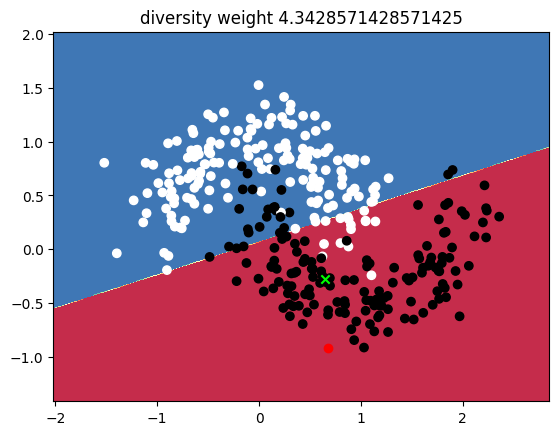

 47%|████████████████████▌                       | 7/15 [00:10<00:12,  1.59s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
5.05
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


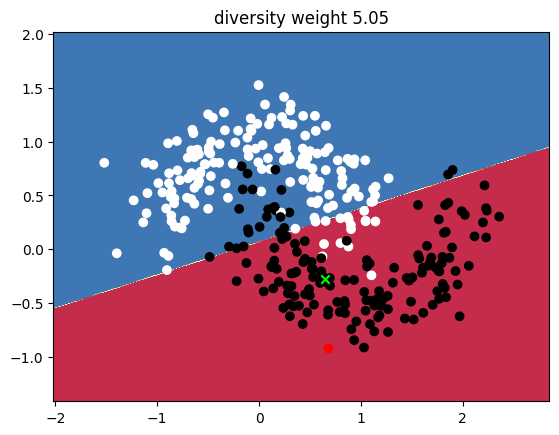

 53%|███████████████████████▍                    | 8/15 [00:12<00:11,  1.58s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
5.757142857142857
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


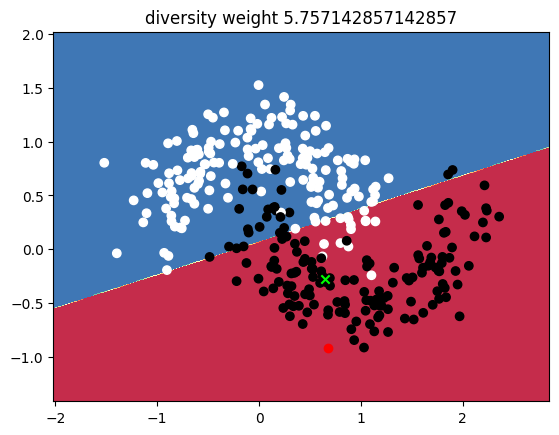

 60%|██████████████████████████▍                 | 9/15 [00:14<00:09,  1.60s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
6.464285714285714
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


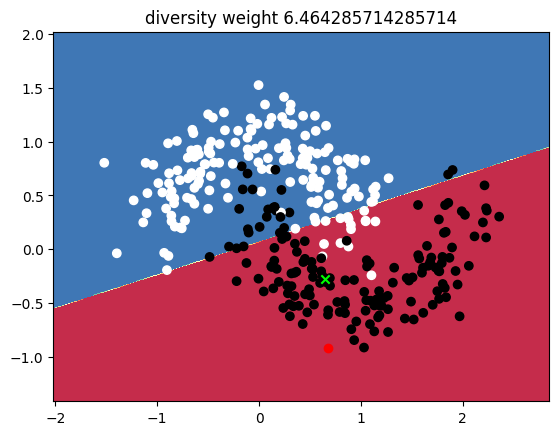

 67%|████████████████████████████▋              | 10/15 [00:15<00:07,  1.55s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
7.171428571428572
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


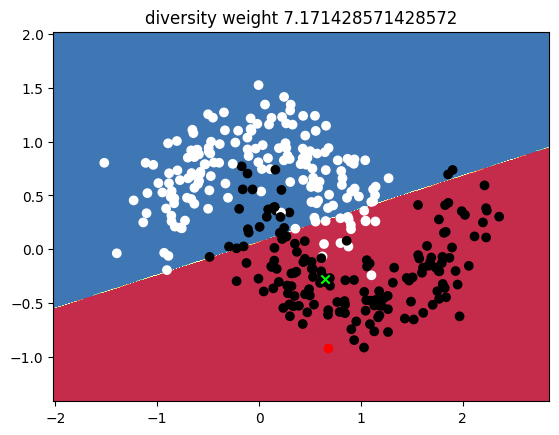

 73%|███████████████████████████████▌           | 11/15 [00:17<00:06,  1.59s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
7.878571428571429
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


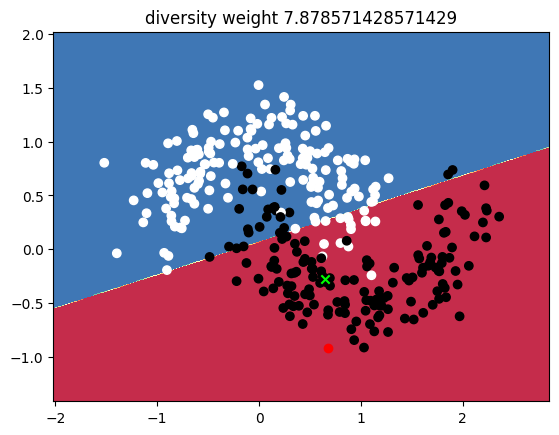

 80%|██████████████████████████████████▍        | 12/15 [00:18<00:04,  1.62s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
8.585714285714285
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


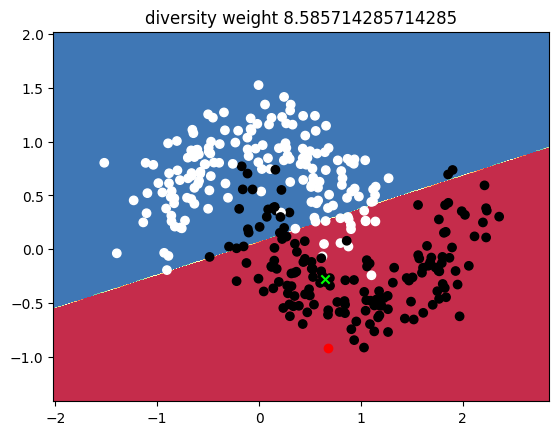

 87%|█████████████████████████████████████▎     | 13/15 [00:20<00:03,  1.59s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
9.292857142857143
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


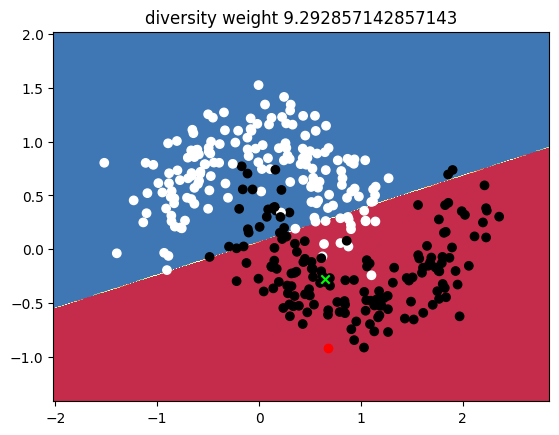

 93%|████████████████████████████████████████▏  | 14/15 [00:22<00:01,  1.60s/it]/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


Diverse Counterfactuals found! total time taken: 00 min 00 sec
10.0
Query instance (original outcome : 0)


/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)
/home/miray/miniconda3/envs/deepdac/lib/python3.9/site-packages/dice_ml/data_interfaces/public_data_interface.py:582: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = self.ohe_base_df.append(query_instance, ignore_index=True, sort=False)


,x,y,target
0,0.651283,-0.280216,0.489



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,0.674792,-0.915829,0


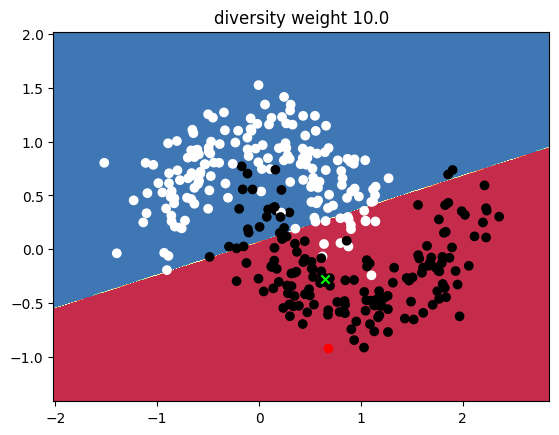

100%|███████████████████████████████████████████| 15/15 [00:23<00:00,  1.57s/it]


In [563]:
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=74
query_instance = dict(zip(['x','y'], x_test[index]))
diversity_weights = np.linspace(0.1, 10, num=15)
pred_ori = counterfactuals.cf_examples_list[0].test_pred
for diversity_weight in tqdm(diversity_weights):
    counterfactuals = explainer.generate_counterfactuals(query_instance=query_instance,total_CFs=1, diversity_weight=diversity_weight,desired_class='opposite')
    print(diversity_weight)
    
    counterfactuals.visualize_as_dataframe()
    if len(counterfactuals.cf_examples_list[0].final_cfs_df.values) >0 :
        plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "diversity weight "+str(diversity_weight),x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )

In [ ]:
feature_weights = {'x': 1, 'y': 1}
model = linearRegression(2,1)
criterion = torch.nn.MSELoss()

grad(x_train, y_train, model, criterion)
model_dice = dice_ml.Model(model=model, backend='PYT')
explainer = dice_ml.Dice(data_dice, model_dice)
index=74
query_instance = dict(zip(['x','y'], x_test[index]))
x_weights = np.linspace(2, 10, num=8)
pred_ori = counterfactuals.cf_examples_list[0].test_pred
for x_weight in tqdm(diversity_weights):
    feature_weights['x'] = x_weight
    counterfactuals = explainer.generate_counterfactuals(query_instance=query_instance,total_CFs=1, diversity_weight=diversity_weight,desired_class='opposite')
    print(diversity_weight)
    
    counterfactuals.visualize_as_dataframe()
    if len(counterfactuals.cf_examples_list[0].final_cfs_df.values) >0 :
        plot_decision_boundary(lambda x : predict(x,model), x_test, y_test.flatten(), "diversity weight "+str(diversity_weight),x_test[index], counterfactuals.cf_examples_list[0].final_cfs_df.values[0][:2] )